# Locating maximum strain on riser by using RNN

### Introduction
This notebook presents a method to predict the location of maximum strain on a riser by using a recurrent neural network (RNN). The data used are from the NDP high mode VIV tests and as a starting point only a single test case is used here. In the test, the acceleration of the riser was measured at 8 locations in cross-flow and in-line direction. The riser strain was measured at 24 locations for cross-flow and 40 locations for in-line. The idea of this model is to use the acceleration measurements to predict which of the 24 cross-flow strain sensors will experience the maximum strain. The prediction is made for each time step and a RNN is applied since measurements close in time are assumed to be correlated.

In [1]:
import scipy.io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, TimeDistributed, Dropout, MaxPooling1D, MaxPooling2D, Conv2D, Input, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from scipy.stats import kurtosis, skew
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import itertools

### Loading data

In [2]:
mat = scipy.io.loadmat('test2010.mat')
chan_names = mat['chan_names']
data = mat['data']

### Preparation of data

First the time vector is generated. The experiments were done with a sampling frequency of 1200 Hz. The initial part and the last part of the data is discarded as it is loaded in. 

The location of the sensors in meters are also included.

The location of the maximum value of the strain is found in CF and IL for each time step.


In [3]:
D = 0.027 # Riser diameter

# Time parameters
t1 = 15 # Start time
t2 = 165 # End time
Fs = 1200 # Sampling freq
dt = 1/Fs # Time step
tst = t1*Fs # Index for start
ted = t2*Fs # Index for end

# Making a time vector
nm = data.shape[1]
time = np.arange(0,nm-1)*dt
time = time[tst:ted].reshape(1,-1)

# Defining feature vectors and cropping them from initial/end effects 
strain_CF = data[46:70,tst:ted]
strain_CF_names = chan_names[46:70]
strain_IL = data[6:46,tst:ted]
strain_IL_names = chan_names[6:46]
pos_IL = data[98:106,tst:ted]
pos_CF = data[106:114,tst:ted]
acc_IL = data[70:78,tst:ted]
acc_IL_names = chan_names[70:78]
acc_CF = data[78:86,tst:ted]
acc_CF_names = chan_names[78:86]
mean_force = data[95:97,tst:ted].mean(axis=0)

# Strain sensor positions
str_il = np.array([1.143,2.555,3.084,3.224,4.155,5.759,6.030,7.664,8.216,8.609,8.889,9.703,10.285,13.676,13.772,
                     15.393,16.452,16.547,16.891,19.997,20.193,21.393,21.603,22.460,23.165,25.153,25.442,26.254,27.532,
                     28.698,28.863,29.365,31.191,31.415,32.796,33.005,35.549,36.559,36.824,37.322])
str_sensor_cf = np.array([2,3,4,5,7,10,11,13,14,17,19,20,21,22,24,25,26,28,31,32,33,36,38,40])-1
str_cf = str_il[str_sensor_cf]

# Accelerometer positions
acc_pos = np.array([4.155,8.609,13.676,16.891,21.393,25.153,28.863,33.005])

# Finding indices for strain locations which will be fused 
sensor_diff_il = np.abs(np.tile(str_il,(8,1)).T - acc_pos)
sensor_transform_index_il = np.argmin(sensor_diff_il,axis=1)
sensor_diff_cf = np.abs(np.tile(str_cf,(8,1)).T - acc_pos)
sensor_transform_index_cf = np.argmin(sensor_diff_cf,axis=1)

# Find maximum strain locations for each time step
max_strain_CF = strain_CF.argmax(axis=0)
max_strain_CF_loc = str_cf[max_strain_CF]

### Preparing data for RNN

An input tensor X, and output vector Y is made.

X is scaled by a standard scaler. Y is the integer to be predicted.

Data are divided into batches, where the time in each batch is conserved.

Each batch is randomly put in either train, test or validation set.

The time is removed from the input.

In [4]:
X = np.vstack((time,strain_IL,strain_CF)).transpose()
Y = np.vstack((acc_IL,acc_CF)).transpose()
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

n_features = X.shape[1]
b_size = 500
n_outputs = Y.shape[1]

n_batches = int(X.shape[0]/b_size)
X = X.reshape(n_batches,b_size,n_features)
Y = Y.reshape(n_batches,b_size,n_outputs)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, shuffle=False)

t_train = X_train[:,:,0]
t_val = X_val[:,:,0]
t_test = X_test[:,:,0]
X_train = X_train[:,:,0:-1]
X_test = X_test[:,:,0:-1]
X_val = X_val[:,:,0:-1]

n_features = n_features-1

In [5]:
print(f'X-shape: (batches, time steps in batch, features) = {X_train.shape}')
print(f'Y-shape: (batches, time steps in batch, output) = {y_train.shape}')

X-shape: (batches, time steps in batch, features) = (202, 500, 64)
Y-shape: (batches, time steps in batch, output) = (202, 500, 16)


### Correlation between strain and acceleration

<AxesSubplot:>

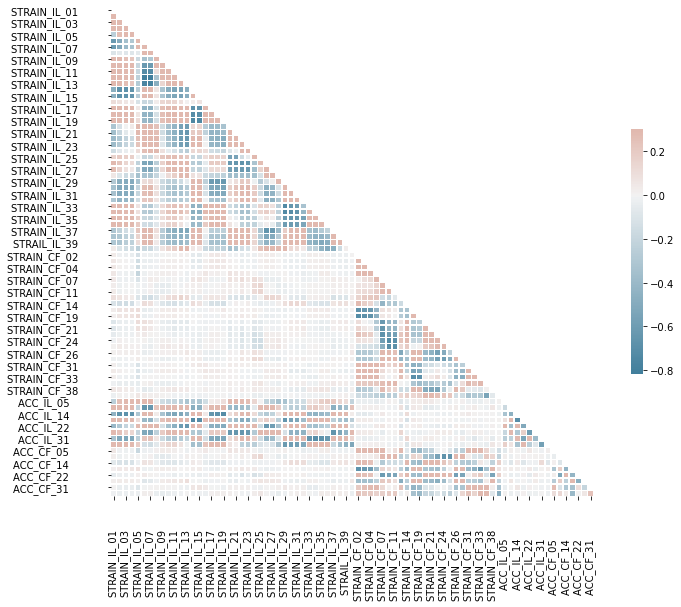

In [6]:
input_output_data = np.vstack((strain_IL,strain_CF,acc_IL,acc_CF)).transpose()
input_output_names = np.hstack((strain_IL_names,strain_CF_names,acc_IL_names,acc_CF_names))
d = pd.DataFrame(data=input_output_data,columns=input_output_names)
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

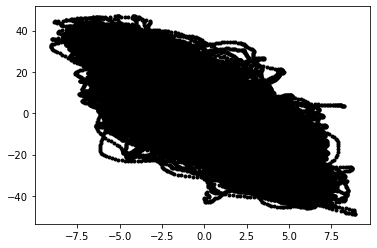

In [7]:
plt.figure
plt.plot(acc_CF[3,:],strain_CF[0,:],'k.')

### Building RNN model

This model will use sparse_categorical_crossentropy, which means that if the true output can be $n \in 0:N$ different integers, then the prediction will be an array of size $N+1$ where each unit indicates a probability of the index.


In [8]:
# Regression
model = Sequential(name='LSTM')
model.add(LSTM(
    units=100,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0.1,
    recurrent_dropout=0.1,
    activation='tanh'))
model.add(Dense(50,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(n_outputs, activation='linear'))

model.summary()
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mean_squared_error'])

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500, 100)          66000     
_________________________________________________________________
dense (Dense)                (None, 500, 50)           5050      
_________________________________________________________________
dropout (Dropout)            (None, 500, 50)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 500, 16)           816       
Total params: 71,866
Trainable params: 71,866
Non-trainable params: 0
_________________________________________________________________


### Training model

Using an early stopping criteria.

Can continue training for a max of 100 epochs.

Validation data is used at each epoch.

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train,y_train,epochs=100,callbacks=callback,validation_data=(X_val, y_val),validation_steps=10,verbose=True)

Epoch 1/100
7/7 [==============================] - 9s 943ms/step - loss: 5.1082 - mean_squared_error: 5.1082 - val_loss: 5.3698 - val_mean_squared_error: 5.3698
Epoch 2/100
7/7 [==============================] - 6s 890ms/step - loss: 4.1069 - mean_squared_error: 4.1069 - val_loss: 4.4231 - val_mean_squared_error: 4.4231
Epoch 3/100
7/7 [==============================] - 6s 895ms/step - loss: 3.4821 - mean_squared_error: 3.4821 - val_loss: 3.7728 - val_mean_squared_error: 3.7728
Epoch 4/100
7/7 [==============================] - 6s 883ms/step - loss: 3.0340 - mean_squared_error: 3.0340 - val_loss: 3.3035 - val_mean_squared_error: 3.3035
Epoch 5/100
7/7 [==============================] - 6s 903ms/step - loss: 2.6948 - mean_squared_error: 2.6948 - val_loss: 2.9290 - val_mean_squared_error: 2.9290
Epoch 6/100
7/7 [==============================] - 7s 959ms/step - loss: 2.4183 - mean_squared_error: 2.4183 - val_loss: 2.6319 - val_mean_squared_error: 2.6319
Epoch 7/100
7/7 [=================

Epoch 52/100
7/7 [==============================] - 7s 946ms/step - loss: 0.7012 - mean_squared_error: 0.7012 - val_loss: 0.4378 - val_mean_squared_error: 0.4378
Epoch 53/100
7/7 [==============================] - 6s 932ms/step - loss: 0.6975 - mean_squared_error: 0.6975 - val_loss: 0.4365 - val_mean_squared_error: 0.4365
Epoch 54/100
7/7 [==============================] - 7s 992ms/step - loss: 0.6926 - mean_squared_error: 0.6926 - val_loss: 0.4288 - val_mean_squared_error: 0.4288
Epoch 55/100
7/7 [==============================] - 7s 980ms/step - loss: 0.6900 - mean_squared_error: 0.6900 - val_loss: 0.4272 - val_mean_squared_error: 0.4272
Epoch 56/100
7/7 [==============================] - 7s 944ms/step - loss: 0.6872 - mean_squared_error: 0.6872 - val_loss: 0.4180 - val_mean_squared_error: 0.4180
Epoch 57/100
7/7 [==============================] - 7s 938ms/step - loss: 0.6826 - mean_squared_error: 0.6826 - val_loss: 0.4155 - val_mean_squared_error: 0.4155
Epoch 58/100
7/7 [==========

In [10]:
y_pred = model.predict(X_test)

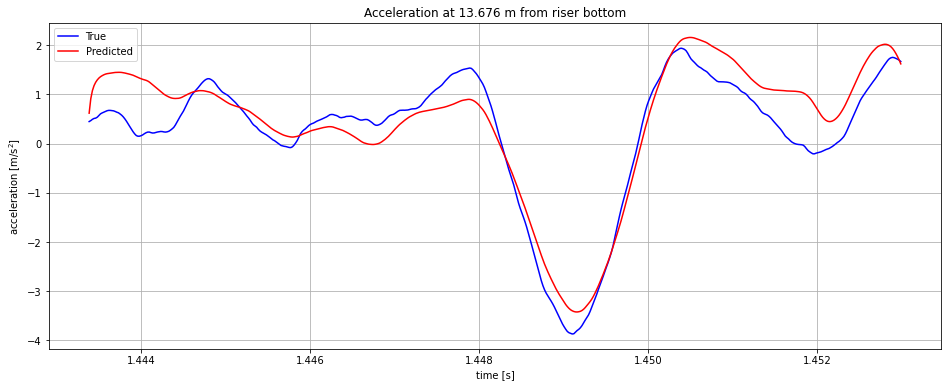

In [11]:
n=60
p=2
plt.figure(figsize=(16,6))
plt.plot(t_test[n,:],y_test[n,:,p],'b-',label='True')
plt.plot(t_test[n,:],y_pred[n,:,p],'r-',label='Predicted')
plt.legend()
plt.ylabel('acceleration [m/s$^2$]')
plt.xlabel('time [s]')
plt.title(f'Acceleration at {acc_pos[p]} m from riser bottom')
plt.grid()
plt.show()

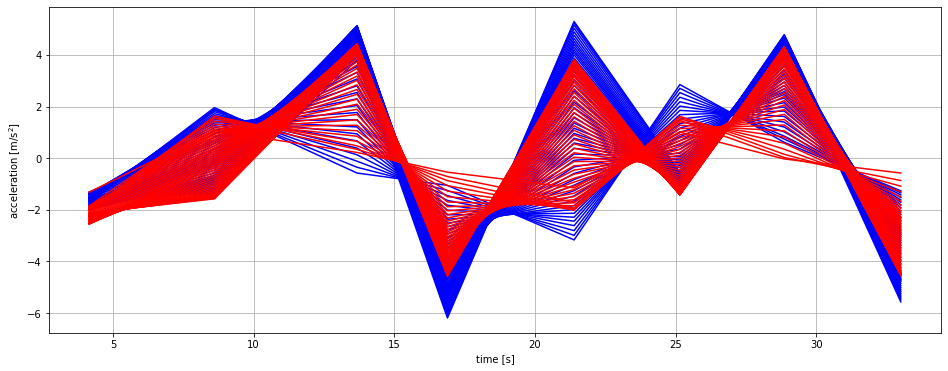

In [33]:
n=20
T=b_size//10
plt.figure(figsize=(16,6))
[plt.plot(acc_pos,y_test[n,it,0:8],'b-',label='True') for it in range(T)]
[plt.plot(acc_pos,y_pred[n,it,0:8],'r-',label='Predicted') for it in range(T)]
#plt.legend()
plt.ylabel('acceleration [m/s$^2$]')
plt.xlabel('time [s]')
plt.grid()
plt.show()

### Predicting IL and CF separately

In [13]:
X_train_CF = X_train[:,:,40:]
X_val_CF = X_val[:,:,40:]
X_test_CF = X_test[:,:,40:]
y_train_CF = y_train[:,:,8:]
y_val_CF = y_val[:,:,8:]
y_test_CF = y_test[:,:,8:]

n_features = X_train_CF.shape[2]
n_outputs = y_train_CF.shape[2]

print(f'X-shape: (batches, time steps in batch, features) = {X_train_CF.shape}')
print(f'Y-shape: (batches, time steps in batch, output) = {y_train_CF.shape}')

X-shape: (batches, time steps in batch, features) = (202, 500, 24)
Y-shape: (batches, time steps in batch, output) = (202, 500, 8)


In [14]:
# Regression
model_CF = Sequential(name='LSTM')
model_CF.add(LSTM(
    units=100,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0.1,
    recurrent_dropout=0.1,
    activation='tanh'))
model_CF.add(Dense(50,activation='tanh'))
model_CF.add(Dropout(0.2))
model_CF.add(Dense(n_outputs, activation='linear'))

model_CF.summary()
model_CF.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mean_squared_error'])

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 500, 100)          50000     
_________________________________________________________________
dense_2 (Dense)              (None, 500, 50)           5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 500, 8)            408       
Total params: 55,458
Trainable params: 55,458
Non-trainable params: 0
_________________________________________________________________


In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_CF.fit(X_train_CF,y_train_CF,epochs=100,callbacks=callback,validation_data=(X_val_CF, y_val_CF),validation_steps=10,verbose=True)

Epoch 1/100
7/7 [==============================] - 6s 638ms/step - loss: 4.7514 - mean_squared_error: 4.7514 - val_loss: 4.7275 - val_mean_squared_error: 4.7275
Epoch 2/100
7/7 [==============================] - 4s 587ms/step - loss: 3.3507 - mean_squared_error: 3.3507 - val_loss: 3.4288 - val_mean_squared_error: 3.4288
Epoch 3/100
7/7 [==============================] - 4s 593ms/step - loss: 2.6601 - mean_squared_error: 2.6601 - val_loss: 2.8277 - val_mean_squared_error: 2.8277
Epoch 4/100
7/7 [==============================] - 4s 635ms/step - loss: 2.2380 - mean_squared_error: 2.2380 - val_loss: 2.4290 - val_mean_squared_error: 2.4290
Epoch 5/100
7/7 [==============================] - 4s 628ms/step - loss: 1.9192 - mean_squared_error: 1.9192 - val_loss: 2.0207 - val_mean_squared_error: 2.0207
Epoch 6/100
7/7 [==============================] - 4s 641ms/step - loss: 1.6654 - mean_squared_error: 1.6654 - val_loss: 1.7306 - val_mean_squared_error: 1.7306
Epoch 7/100
7/7 [=================

7/7 [==============================] - 4s 632ms/step - loss: 0.5611 - mean_squared_error: 0.5611 - val_loss: 0.3557 - val_mean_squared_error: 0.3557
Epoch 52/100
7/7 [==============================] - 4s 639ms/step - loss: 0.5537 - mean_squared_error: 0.5537 - val_loss: 0.3558 - val_mean_squared_error: 0.3558
Epoch 53/100
7/7 [==============================] - 4s 619ms/step - loss: 0.5527 - mean_squared_error: 0.5527 - val_loss: 0.3520 - val_mean_squared_error: 0.3520
Epoch 54/100
7/7 [==============================] - 4s 582ms/step - loss: 0.5461 - mean_squared_error: 0.5461 - val_loss: 0.3426 - val_mean_squared_error: 0.3426
Epoch 55/100
7/7 [==============================] - 4s 620ms/step - loss: 0.5434 - mean_squared_error: 0.5434 - val_loss: 0.3428 - val_mean_squared_error: 0.3428
Epoch 56/100
7/7 [==============================] - 4s 614ms/step - loss: 0.5414 - mean_squared_error: 0.5414 - val_loss: 0.3361 - val_mean_squared_error: 0.3361
Epoch 57/100
7/7 [=======================

In [16]:
y_pred_CF = model_CF.predict(X_test_CF)

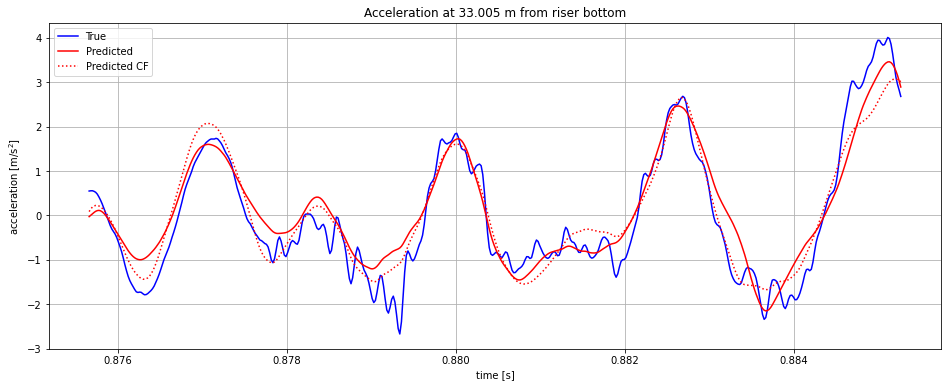

In [29]:
n=1
p=7
plt.figure(figsize=(16,6))
plt.plot(t_test[n,:],y_test[n,:,p+8],'b-',label='True')
plt.plot(t_test[n,:],y_pred[n,:,p+8],'r-',label='Predicted')
plt.plot(t_test[n,:],y_pred_CF[n,:,p],'r:',label='Predicted CF')
plt.legend()
plt.ylabel('acceleration [m/s$^2$]')
plt.xlabel('time [s]')
plt.title(f'Acceleration at {acc_pos[p]} m from riser bottom')
plt.grid()
plt.show()